# Instacart Customer Segmentation Analysis

The Instacart dataset for prior orders, is quite large.  However, it could provide quite a bit of insight in our customer behavior, without touching our specified training and test sets.  The dataset provided by Instacart, has already been split between prior, train and test.  In order to avoid overfitting my training models, I will first leverage the prior dataset as a pre-training data set.

Also market basket analysis can be quite memory intensive.  As such, I would like to first attempt to segment my customers using RFM (Recency Frequency Monetary Value) in order to further reduce my dataset before running any models.  The instacart dataset doesn't provide the revenue figures or the sales prices for any of the products in the dataset.  Therefore, for this exercise, we will make the assumption that the number of products each customer ordered, could be an indicator of the Monetary value.

The recency of purchases has been provided by Instacart for the last 30 days.  We will leverage the number of orders placed by each customer as the frequency within the last month.  And lastly, we will use the number of products purchased within the period as a substitue for monetary value.

In [27]:
#import libraries

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer

from sklearn.decomposition import PCA

from openTSNE import TSNE

#packages for clustering

from sklearn.cluster import KMeans

#set random seed for preprocessing and clustering steps
random_seed = 30

In [28]:
#load prior order information from datawrangling notebook
df = pd.read_csv('../cleaned_data_files/combo_order_prod_prior.csv')
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [29]:
df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,30356421.00
mean,1710748.52,25576.34,8.35,0.59,102937.24,17.14,2.74,13.42,11.10
std,987300.70,14096.69,7.13,0.49,59466.48,17.54,2.09,4.25,8.78
min,2.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,855943.00,13530.00,3.00,0.00,51421.00,5.00,1.00,10.00,5.00
50%,1711048.00,25256.00,6.00,1.00,102611.00,11.00,3.00,13.00,8.00
75%,2565514.00,37935.00,11.00,1.00,154391.00,24.00,5.00,16.00,15.00
max,3421083.00,49688.00,145.00,1.00,206209.00,99.00,6.00,23.00,30.00


There are roughly 2 million order records missing the days_since_prior_order value.  The dataset overview is silent with regard to whether that should be interpreted as 0 or over 30 days.  The dataset noted that it didn't capture prior order dates over 30 days.  Therefore, for purposes of customer segmentation, we will fill the missing values with the median value of 8.

In [30]:
#replace missing days_since_prior_order with the median value
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(df['days_since_prior_order'].median())
df.describe().round(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00,32434489.00
mean,1710748.52,25576.34,8.35,0.59,102937.24,17.14,2.74,13.42,10.91
std,987300.70,14096.69,7.13,0.49,59466.48,17.54,2.09,4.25,8.53
min,2.00,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,855943.00,13530.00,3.00,0.00,51421.00,5.00,1.00,10.00,5.00
50%,1711048.00,25256.00,6.00,1.00,102611.00,11.00,3.00,13.00,8.00
75%,2565514.00,37935.00,11.00,1.00,154391.00,24.00,5.00,16.00,14.00
max,3421083.00,49688.00,145.00,1.00,206209.00,99.00,6.00,23.00,30.00


In [31]:
df.user_id.nunique()

206209

In [32]:
df_202279 = df[df['user_id']==202279]
df_202279.order_id.nunique()


8

In [33]:
#obtain the max recency number for each user_id / customer
recency_202279 = df_202279.groupby('user_id')['days_since_prior_order'].mean()
recency_202279

user_id
202279    20.322222
Name: days_since_prior_order, dtype: float64

In [34]:
#create recency for entire dataset

customer_recency = df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
customer_recency.tail()

,user_id,days_since_prior_order
206204,206205,13.937500
206205,206206,4.098246
206206,206207,14.139013
206207,206208,7.451994
206208,206209,19.038760


In [35]:
#rename the days_since_prior_order column to recency
customer_recency.rename(columns={'days_since_prior_order':'recency'}, inplace=True)

In [36]:
#calculate the frequency of  by customer (user_id)
customer_frequency = df.groupby('user_id')['order_id'].nunique().reset_index()


In [37]:
#rename the order_id column to frequency
customer_frequency.rename(columns={'order_id':'frequency'}, inplace=True)

In [38]:
frequency_202279 = customer_frequency[customer_frequency['user_id']==202279]
frequency_202279


,user_id,frequency
202278,202279,8


In [39]:
#calculate the number of products ordered by customer(user_id)
customer_monetary = df.groupby('user_id')['product_id'].count().reset_index()
customer_monetary.describe()


,user_id,product_id
count,206209.000000,206209.000000
mean,103105.000000,157.289396
std,59527.555167,204.208233
min,1.000000,3.000000
25%,51553.000000,39.000000
50%,103105.000000,83.000000
75%,154657.000000,188.000000
max,206209.000000,3725.000000


In [40]:
#rename the product_id column to monetary
customer_monetary.rename(columns={'product_id':'monetary'}, inplace=True)

## Create the rankings for Recency, Frequency and Monetary Values

The ranking for recency is based on the most recent purchase in days.  Therefore, the lower the value for recency the higher the ranking.  All the following rankings are based on 1=best and 3=worst.

In [41]:
#ranking for recency
customer_recency['rank_recency'] = customer_recency['recency'].rank(method='first',pct=True)
customer_recency.head()

,user_id,recency,rank_recency
0,1,19.220339,0.784520
1,2,15.435897,0.593640
2,3,11.090909,0.347371
3,4,13.722222,0.497005
4,5,12.567568,0.431402


In [42]:
#ranking for frequency will be the opposite, because a higher frequency is th desired outcome
customer_frequency['rank_frequency'] = customer_frequency['frequency'].rank(method='first', ascending=False, pct=True)
customer_frequency.head()

,user_id,frequency,rank_frequency
0,1,10,0.455276
1,2,14,0.338928
2,3,12,0.391321
3,4,5,0.710294
4,5,4,0.788685


In [43]:
#ranking for monetary value will also have a higher value as the desired outcome
customer_monetary['rank_monetary'] = customer_monetary['monetary'].rank(ascending=False, pct=True)
customer_monetary.head()

,user_id,monetary,rank_monetary
0,1,59,0.616520
1,2,195,0.240530
2,3,88,0.481461
3,4,18,0.917671
4,5,37,0.765696


In [44]:
#combine the 3 dataframes into a new RFM dataframe
RFM_df = customer_recency.merge(customer_frequency, on='user_id').merge(customer_monetary, on='user_id')
RFM_df.describe().round(2)

,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary
count,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00,206209.00
mean,103105.00,14.11,0.50,15.59,0.50,157.29,0.50
std,59527.56,5.80,0.29,16.65,0.29,204.21,0.29
min,1.00,0.40,0.00,3.00,0.00,3.00,0.00
25%,51553.00,9.38,0.25,5.00,0.25,39.00,0.25
50%,103105.00,13.77,0.50,9.00,0.50,83.00,0.50
75%,154657.00,18.47,0.75,19.00,0.75,188.00,0.75
max,206209.00,29.78,1.00,99.00,1.00,3725.00,1.00


In [45]:
#take the ranking and bin them into categories
bins = [0, 0.33, 0.67, 1]
bin_names = ['1', '2', '3'] 

#create the final dataframe with our standardized rankings
final_df = pd.DataFrame(customer_recency['user_id'])
final_df['recency'] = pd.cut(RFM_df['rank_recency'], bins, labels = bin_names).astype('str')
final_df['frequency'] = pd.cut(RFM_df['rank_frequency'], bins, labels = bin_names).astype('str')
final_df['monetary'] = pd.cut(RFM_df['rank_recency'], bins, labels = bin_names).astype('str')

final_df

,user_id,recency,frequency,monetary
0,1,3,2,3
1,2,2,2,2
2,3,2,2,2
3,4,2,3,2
4,5,2,3,2
...,...,...,...,...
206204,206205,2,3,2
206205,206206,1,1,1
206206,206207,2,1,2
206207,206208,1,1,1


In [46]:
final_df['rfm_rank'] = final_df['recency'] + final_df['frequency'] + final_df['monetary']
final_df

,user_id,recency,frequency,monetary,rfm_rank
0,1,3,2,3,323
1,2,2,2,2,222
2,3,2,2,2,222
3,4,2,3,2,232
4,5,2,3,2,232
...,...,...,...,...,...
206204,206205,2,3,2,232
206205,206206,1,1,1,111
206206,206207,2,1,2,212
206207,206208,1,1,1,111


In [47]:
# add the new RFM_rank feature to my RFM_df
RFM_df['rfm_rank'] = final_df['rfm_rank']
RFM_df

,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary,rfm_rank
0,1,19.220339,0.784520,10,0.455276,59,0.616520,323
1,2,15.435897,0.593640,14,0.338928,195,0.240530,222
2,3,11.090909,0.347371,12,0.391321,88,0.481461,222
3,4,13.722222,0.497005,5,0.710294,18,0.917671,232
4,5,12.567568,0.431402,4,0.788685,37,0.765696,232
...,...,...,...,...,...,...,...,...
206204,206205,13.937500,0.509294,3,1.000000,32,0.804625,232
206205,206206,4.098246,0.018093,67,0.023214,285,0.153650,111
206206,206207,14.139013,0.521088,16,0.316650,223,0.208046,212
206207,206208,7.451994,0.141395,49,0.055594,677,0.033573,111


In [48]:
rfm_counts = RFM_df.groupby('rfm_rank')['user_id'].count()
rfm_counts

rfm_rank
111    39392
121    14251
131    14405
212    24707
222    25203
232    20202
313     3949
323    30658
333    33442
Name: user_id, dtype: int64

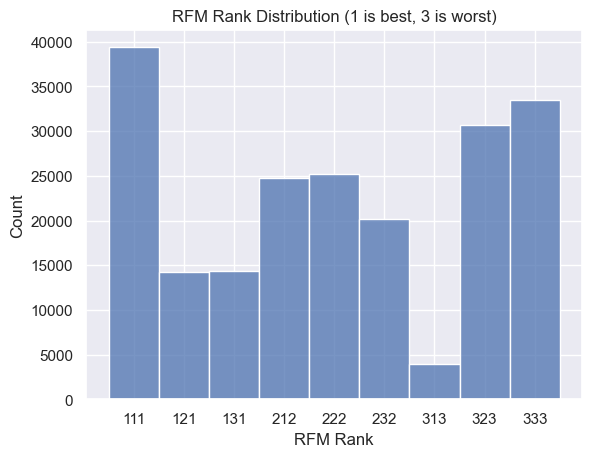

<Figure size 640x480 with 0 Axes>

In [49]:
#create a visualization of the various rankings
RFM_df_sorted = RFM_df.sort_values(by='rfm_rank')

sns.histplot(data=RFM_df_sorted, x='rfm_rank')
plt.title('RFM Rank Distribution (1 is best, 3 is worst)')
plt.xlabel('RFM Rank')
plt.show()

#write the figure to an SVG file    
plt.savefig('../visualizations/RFM_rank_distribution.svg', format='svg')

# Clustering with K-means

We will need to pre-process our data prior to clustering by RFM.  The steps we will take are:
* Review the distribution of our features and resolve any issues with skewness
* Normalize our data
* Determine the ideal number of clusters using an elbow plot

### Reviewing feature distributions

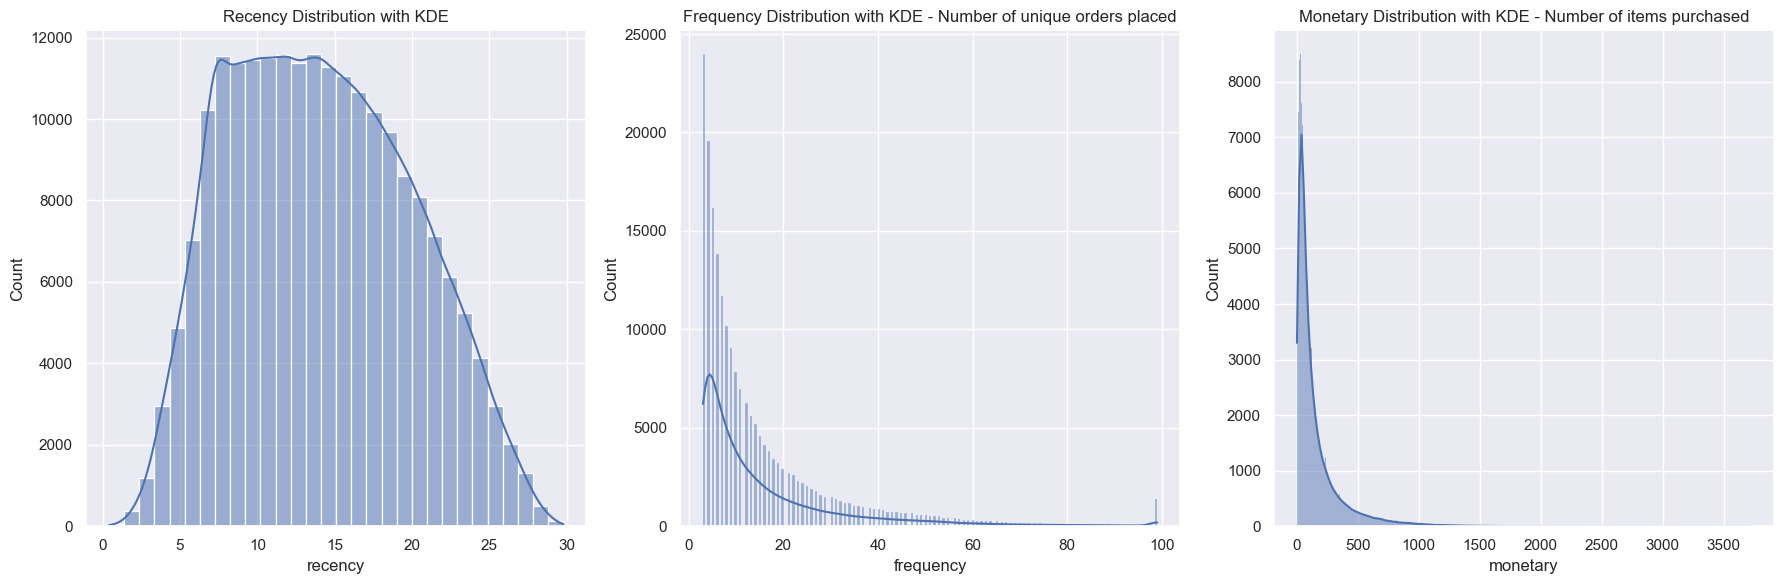

<Figure size 640x480 with 0 Axes>

In [50]:
#review the distributions for RFM
fig, axes = plt.subplots(1,3, figsize=(18, 6))
sns.histplot(RFM_df['recency'], ax=axes[0], bins=30, kde=True)
axes[0].set_title('Recency Distribution with KDE')

sns.histplot(RFM_df['frequency'], ax=axes[1], kde=True)
axes[1].set_title('Frequency Distribution with KDE - Number of unique orders placed')

sns.histplot(RFM_df['monetary'], ax=axes[2], kde=True)
axes[2].set_title('Monetary Distribution with KDE - Number of items purchased')

plt.tight_layout()
plt.show()

#write the figure to an SVG file
plt.savefig('../visualizations/RFM_distributions_kde.svg', format='svg')

Recency looks pretty good. Now frequency and monetary values are skewed to the right. As each of the features contain only positive values, we will try to normalize the data using a logarithmic transformation. 

In [51]:
#create logarithmic transformations to each feature
RFM_df['frequency_log'] = np.log(RFM_df['frequency'])
RFM_df['monetary_log'] = np.log(RFM_df['monetary'])

RFM_df.head()


,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary,rfm_rank,frequency_log,monetary_log
0,1,19.220339,0.784520,10,0.455276,59,0.616520,323,2.302585,4.077537
1,2,15.435897,0.593640,14,0.338928,195,0.240530,222,2.639057,5.273000
2,3,11.090909,0.347371,12,0.391321,88,0.481461,222,2.484907,4.477337
3,4,13.722222,0.497005,5,0.710294,18,0.917671,232,1.609438,2.890372
4,5,12.567568,0.431402,4,0.788685,37,0.765696,232,1.386294,3.610918


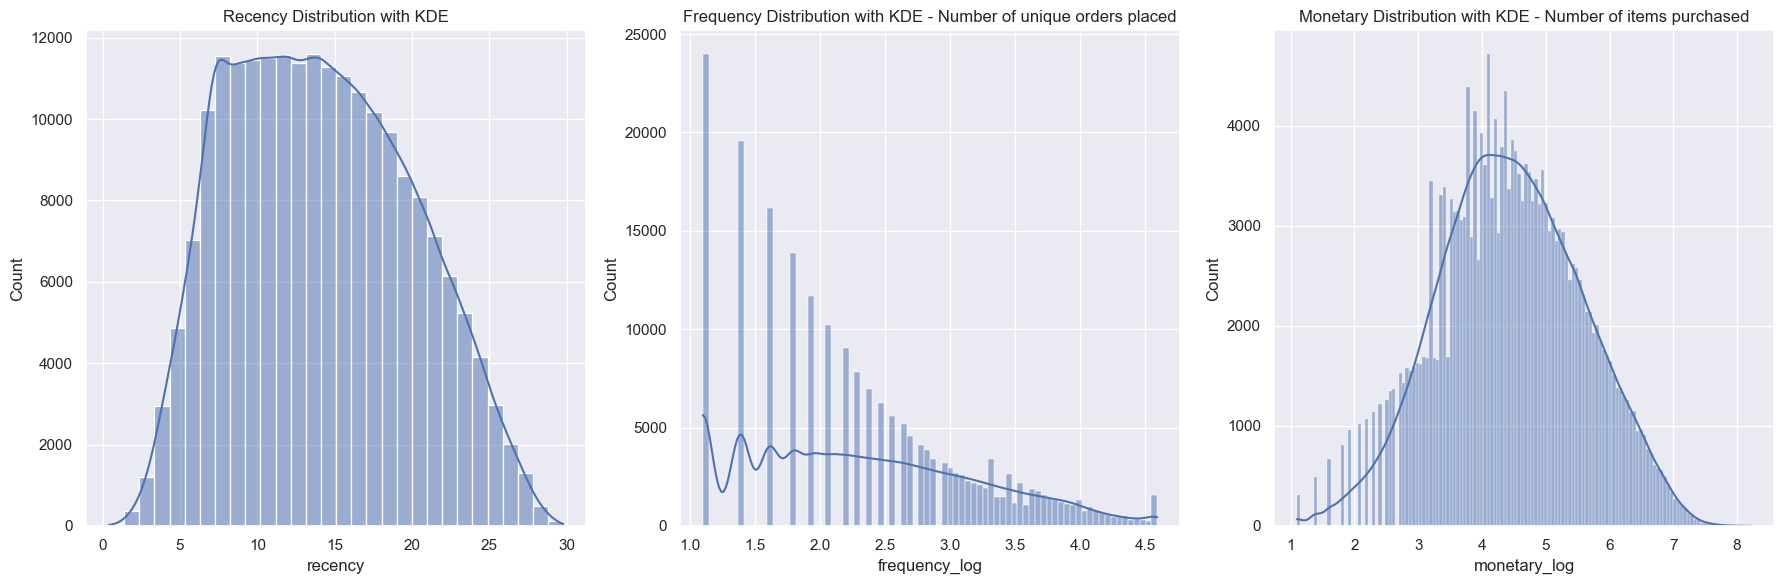

<Figure size 640x480 with 0 Axes>

In [52]:
#review the distributions for RFM log transformed values
fig, axes = plt.subplots(1,3, figsize=(18, 6))
sns.histplot(RFM_df['recency'], ax=axes[0], bins=30, kde=True)
axes[0].set_title('Recency Distribution with KDE')

sns.histplot(RFM_df['frequency_log'], ax=axes[1], kde=True)
axes[1].set_title('Frequency Distribution with KDE - Number of unique orders placed')

sns.histplot(RFM_df['monetary_log'], ax=axes[2], kde=True)
axes[2].set_title('Monetary Distribution with KDE - Number of items purchased')

plt.tight_layout()
plt.show()

#write the figure to an SVG file    
plt.savefig('../visualizations/RFM_distributions_log_kde.svg', format='svg')


Recency and monetary value look pretty good.  Frequency is sitll slightly skewed.  We will try quantile transformation for the frequency feature.

In [53]:
#initialize the quantile transformer
qt = QuantileTransformer(output_distribution='normal', random_state=random_seed)

#fit and transform the frequency feature
frequency_qt = qt.fit_transform(RFM_df[['frequency']])

#concat new column to RFM_df 
RFM_df['frequency_qt'] = frequency_qt

RFM_df.head()

,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary,rfm_rank,frequency_log,monetary_log,frequency_qt
0,1,19.220339,0.784520,10,0.455276,59,0.616520,323,2.302585,4.077537,0.045180
1,2,15.435897,0.593640,14,0.338928,195,0.240530,222,2.639057,5.273000,0.362850
2,3,11.090909,0.347371,12,0.391321,88,0.481461,222,2.484907,4.477337,0.216204
3,4,13.722222,0.497005,5,0.710294,18,0.917671,232,1.609438,2.890372,-0.695908
4,5,12.567568,0.431402,4,0.788685,37,0.765696,232,1.386294,3.610918,-1.002056


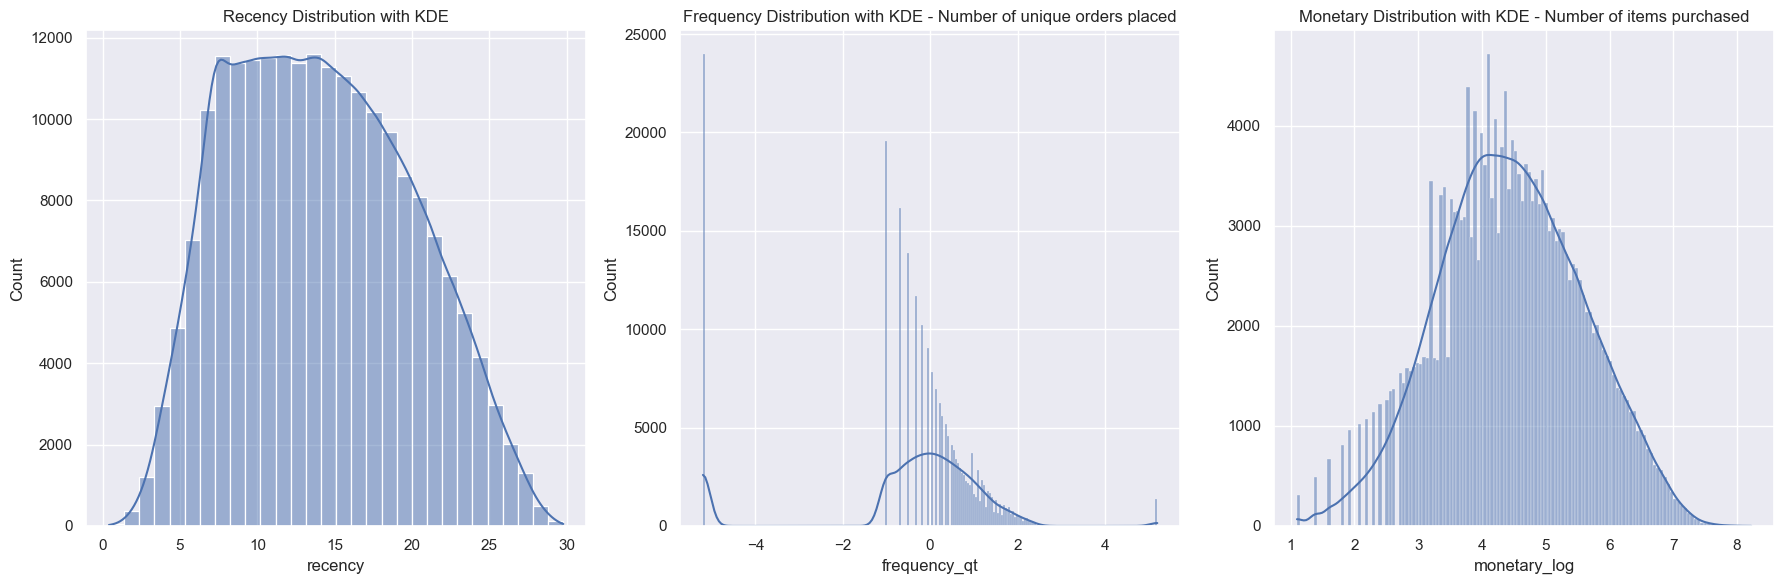

<Figure size 640x480 with 0 Axes>

In [54]:
#review the distributions for RFM log transformed values
fig, axes = plt.subplots(1,3, figsize=(18, 6))
sns.histplot(RFM_df['recency'], ax=axes[0], bins=30, kde=True)
axes[0].set_title('Recency Distribution with KDE')

sns.histplot(RFM_df['frequency_qt'], ax=axes[1], kde=True)
axes[1].set_title('Frequency Distribution with KDE - Number of unique orders placed')

sns.histplot(RFM_df['monetary_log'], ax=axes[2], kde=True)
axes[2].set_title('Monetary Distribution with KDE - Number of items purchased')

plt.tight_layout()
plt.show()

#write the figure to an SVG file
plt.savefig('../visualizations/RFM_distributions_qt_kde.svg', format='svg')


Now that we have reduced the skweness of the RFM_df.  We will now scale the data.

In [55]:
RFM_df.columns

Index(['user_id', 'recency', 'rank_recency', 'frequency', 'rank_frequency',
       'monetary', 'rank_monetary', 'rfm_rank', 'frequency_log',
       'monetary_log', 'frequency_qt'],
      dtype='object')

### Normalizing our data

In [56]:
#Drop all unnecessary columns prior to scaling the data
columns_drop = ['user_id','rank_recency', 'frequency', 'rank_frequency', 'monetary', 'rank_monetary', 'frequency_log', 'rfm_rank']
RFM_scaled = RFM_df.copy().drop(columns=columns_drop)
RFM_scaled.head()

,recency,monetary_log,frequency_qt
0,19.220339,4.077537,0.045180
1,15.435897,5.273000,0.362850
2,11.090909,4.477337,0.216204
3,13.722222,2.890372,-0.695908
4,12.567568,3.610918,-1.002056


In [57]:
RFM_scaled.describe()

,recency,monetary_log,frequency_qt
count,206209.000000,206209.000000,206209.000000
mean,14.105594,4.445261,-0.408749
std,5.797758,1.129352,1.936095
min,0.401818,1.098612,-5.199338
25%,9.382353,3.663562,-0.695908
50%,13.774359,4.418841,-0.056486
75%,18.473214,5.236442,0.650274
max,29.782178,8.222822,5.199338


In [58]:
#normalize the data with StandardSclaer
scaler_rfm = StandardScaler()

#fit and transform data
RFM_normalized = scaler_rfm.fit_transform(RFM_scaled)
RFM_normalized

array([[ 0.88219573, -0.32560713,  0.23445621],
       [ 0.22945187,  0.73293397,  0.39853453],
       [-0.5199756 ,  0.02840163,  0.32279095],
       ...,
       [ 0.00576417,  0.85173891,  0.46384984],
       [-1.1476189 ,  1.83504851,  1.03866996],
       [ 0.85087677,  0.36707078,  0.36161298]])

### Elbow method to find optimal number of clusters


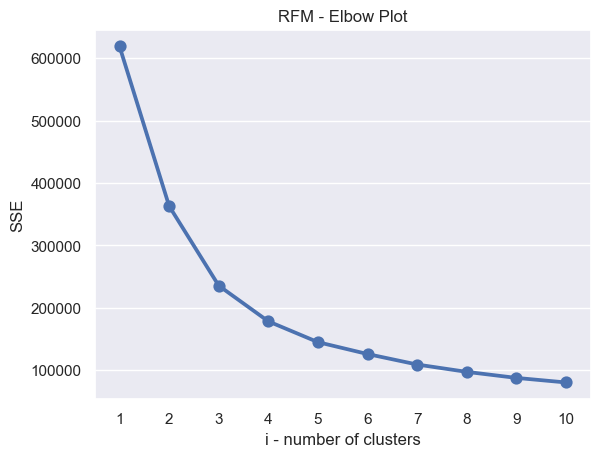

In [59]:
# fit kmeans and calculate the SSE (sum of sqared errors)
sse = {}

#loop through n_cluster values
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state=random_seed)
    kmeans.fit(RFM_normalized)
    sse[i] = kmeans.inertia_
    
#plot the Elbow Chart
plt.title('RFM - Elbow Plot')
plt.xlabel('i - number of clusters')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

plt.show()

Our best n_cluster value appears to be 3.  

In [60]:
#instantiate the kmeans model with clusters = 3
model = KMeans(n_clusters=3, random_state=random_seed)

#fit the model to predict the labels
model.fit(RFM_normalized)


KMeans(n_clusters=3, random_state=30)

In [61]:
cluster_labels = model.predict(RFM_normalized)
print(cluster_labels)

[0 2 2 ... 2 2 0]


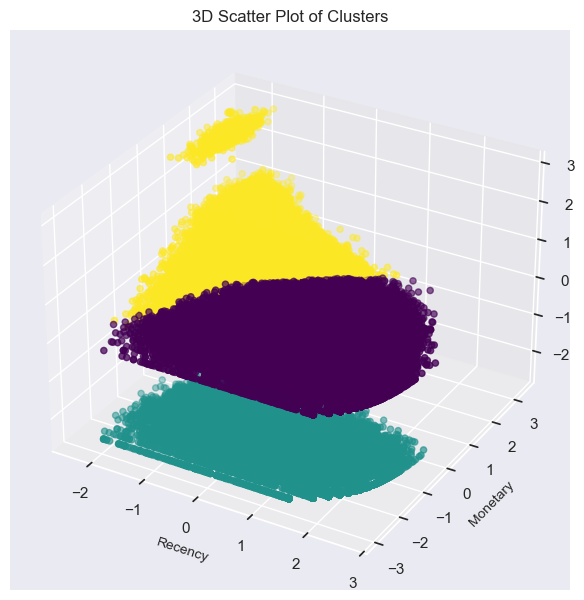

<Figure size 640x480 with 0 Axes>

In [62]:
#let's review the clustering
x = RFM_normalized[:, 0]
y = RFM_normalized[:, 1]
z = RFM_normalized[:, 2]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x, ys=y, zs=z, c=cluster_labels, cmap='viridis')

# Add axis labels 
ax.set_xlabel('Recency', fontsize=10)
ax.set_ylabel('Monetary', fontsize=10)
ax.set_zlabel('Frequency', fontsize=10, labelpad=15)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.title('3D Scatter Plot of Clusters', fontsize=12)
plt.show()

#write the figure to an SVG file
plt.savefig('../visualizations/RFM_clusters_3d.svg', format='svg')

I will flatten the display to better visualize the clusters using t-SNE

In [63]:
#instantiate my t-SNE model
#tsne_model = TSNE()
#transformed_kmeans = tsne_model.fit_transform(RFM_normalized)

#instantiate open t-SNE
tsne_model = TSNE( n_components = 2,
perplexity = 30, 
n_iter=300,
learning_rate=200.0,
random_state=random_seed
)

transformed_kmeans = tsne_model.fit(RFM_normalized)


In [64]:
print(transformed_kmeans)

[[-3.07219756  5.78706404]
 [ 4.92482939  7.30326483]
 [ 1.66692301 -4.03100989]
 ...
 [ 5.99248798  6.16293806]
 [11.86528805  0.14085479]
 [ 1.5503705   9.65148215]]


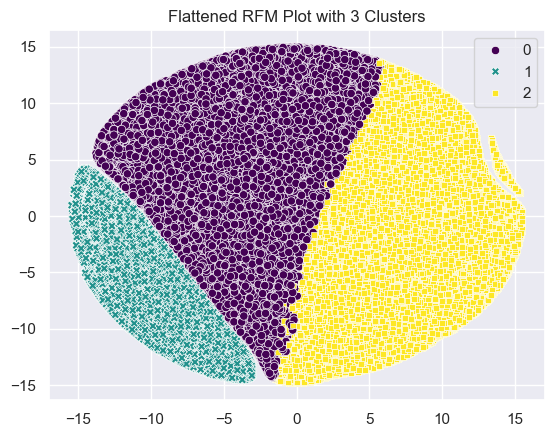

In [65]:
#plot the t-SNE
plt.title('Flattened RFM Plot with 3 Clusters')
sns.scatterplot(x=transformed_kmeans[:,0], y=transformed_kmeans[:,1],
                hue=cluster_labels, style=cluster_labels, palette='viridis')

#write the figure to an SVG file
plt.savefig('../visualizations/RFM_clusters_tSNE.svg', format='svg')

In [66]:
#add my new clusters to the RFM_df dataframe
RFM_scaled['cluster'] = cluster_labels
RFM_scaled.head()

,recency,monetary_log,frequency_qt,cluster
0,19.220339,4.077537,0.045180,0
1,15.435897,5.273000,0.362850,2
2,11.090909,4.477337,0.216204,2
3,13.722222,2.890372,-0.695908,0
4,12.567568,3.610918,-1.002056,0


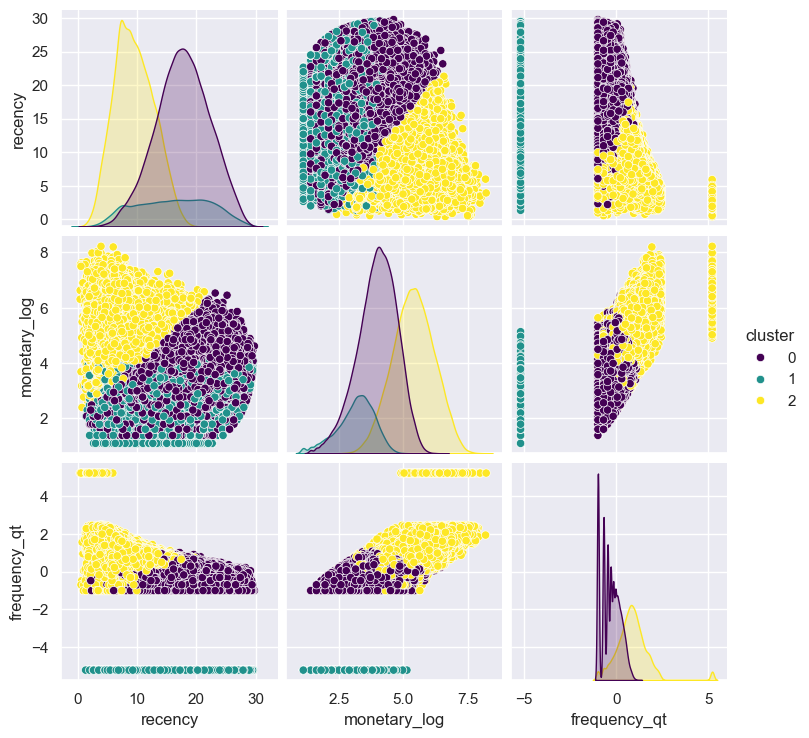

In [67]:
#compare using pairplots
sns.pairplot(data=RFM_scaled, hue='cluster', palette='viridis')

Based on our pair plots, we can see that Cluster 2 could represent our most loyal customers.  They appear to have the most recent prior purchasing experience with Instacart, the highest monetary value (represented here by the number of items purchased as revenue / sales prices were not given), and the most frequent purchases.  

Cluster 0 appears to be core customers.  They still shop with us a few times per month, not as recently as the Cluster 0 customers.  They buy just slightly less on average than our most loyal customers, with average frequency.

Cluster 1, appears to be our least active, infrequent/occaisonal shoppers.  

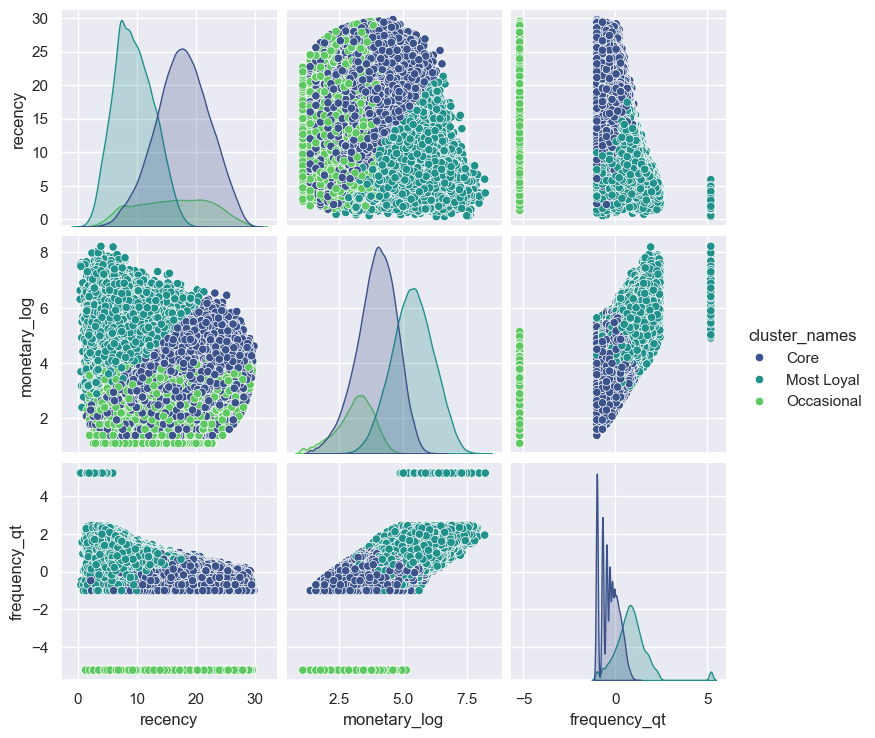

In [68]:
#rename our clusters based on these observations.
RFM_scaled['cluster_names'] = RFM_scaled['cluster'].map({0: 'Core', 1: 'Occasional', 2:'Most Loyal'})  

#replot pairplots with cluster names
sns.pairplot(data=RFM_scaled.drop(columns=['cluster']), hue='cluster_names', palette='viridis')

#write the figure to an SVG file
plt.savefig('../visualizations/RFM_clusters_pairplot.svg', format='svg')


In [69]:
#add the cluster information to the RFM_df dataframe and export to csv
RFM_df['cluster'] = cluster_labels

#add in the cluster names
RFM_df['cluster_names'] = RFM_df['cluster'].map({0: 'Core', 1: 'Occasional', 2:'Most Loyal'}) 
RFM_df.tail(25)

,user_id,recency,rank_recency,frequency,rank_frequency,monetary,rank_monetary,rfm_rank,frequency_log,monetary_log,frequency_qt,cluster,cluster_names
206184,206185,21.666667,0.882498,10,0.493170,90,0.474014,323,2.302585,4.499810,0.045180,0,Core
206185,206186,14.625000,0.548604,3,0.999995,32,0.804625,232,1.098612,3.465736,-5.199338,1,Occasional
206186,206187,9.743295,0.270269,34,0.115727,261,0.171809,111,3.526361,5.564520,1.189522,2,Most Loyal
206187,206188,23.936508,0.947160,7,0.643119,63,0.593910,323,1.945910,4.143135,-0.311059,0,Core
206188,206189,15.675000,0.606414,6,0.710289,40,0.742972,232,1.791759,3.688879,-0.478025,0,Core
206189,206190,17.870370,0.721089,8,0.586386,54,0.646288,323,2.079442,3.988984,-0.175278,0,Core
206190,206191,17.536585,0.704285,5,0.788676,82,0.505269,333,1.609438,4.406719,-0.695908,0,Core
206191,206192,12.223301,0.412160,14,0.364097,103,0.428779,222,2.639057,4.634729,0.362850,2,Most Loyal
206192,206193,4.527697,0.026260,41,0.082523,343,0.119115,111,3.713572,5.837730,1.381364,2,Most Loyal
206193,206194,16.141732,0.631641,11,0.455271,127,0.362057,222,2.397895,4.844187,0.133379,0,Core


In [70]:
#export my RFM table for modelling scenarios

RFM_df.to_csv('../cleaned_data_files/customer_segmentation_data.csv', index=False)